In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from lightgbm import LGBMClassifier
from numpy as np

pd.set_option("display.max_columns", 100)

In [2]:
base_data = pd.read_csv("dataset.csv")
base_data.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,cat_activites,SBA_loan_float,bank_loan_float,crisis
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",45,48000.0,60000.0,2


In [3]:
data = base_data[["State", "ApprovalFY", "Term", "NoEmp", "UrbanRural", "cat_activites", "bank_loan_float", "MIS_Status", "SBA_loan_float", "FranchiseCode", "LowDoc"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, data["MIS_Status"], test_size=0.1, random_state=42, stratify=data["MIS_Status"])

X_train = X_train.drop("MIS_Status", axis=1)
X_test = X_test.drop("MIS_Status", axis=1)


In [5]:
preprocessor = make_pipeline(make_column_transformer((OneHotEncoder(), ["State", "LowDoc"]),remainder="passthrough"))

In [6]:
model = make_pipeline(preprocessor, RandomForestClassifier(10, max_depth=5, random_state=42))

model.fit(X_train, y_train)



/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['State',
                                                                    'LowDoc'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=10,
                                        random_state=42))])

In [7]:
y_pred = model.predict(X_test)


In [8]:
y_pred_encoded = []
for y in y_pred:
    if y == "P I F":
        y_pred_encoded.append(1)
    else :
        y_pred_encoded.append(0)


In [9]:
probabilities = model.predict_proba(X_test)[:,1]

In [10]:
print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.8334698800242695
Test score :  0.8333574296295473
ROC-AUC score : 0.5274265668546929
F1-Score :  0.9081198415521026


In [11]:
print(classification_report(y_test, y_pred=y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.91      0.06      0.11     15782
       P I F       0.83      1.00      0.91     74135

    accuracy                           0.83     89917
   macro avg       0.87      0.53      0.51     89917
weighted avg       0.85      0.83      0.77     89917



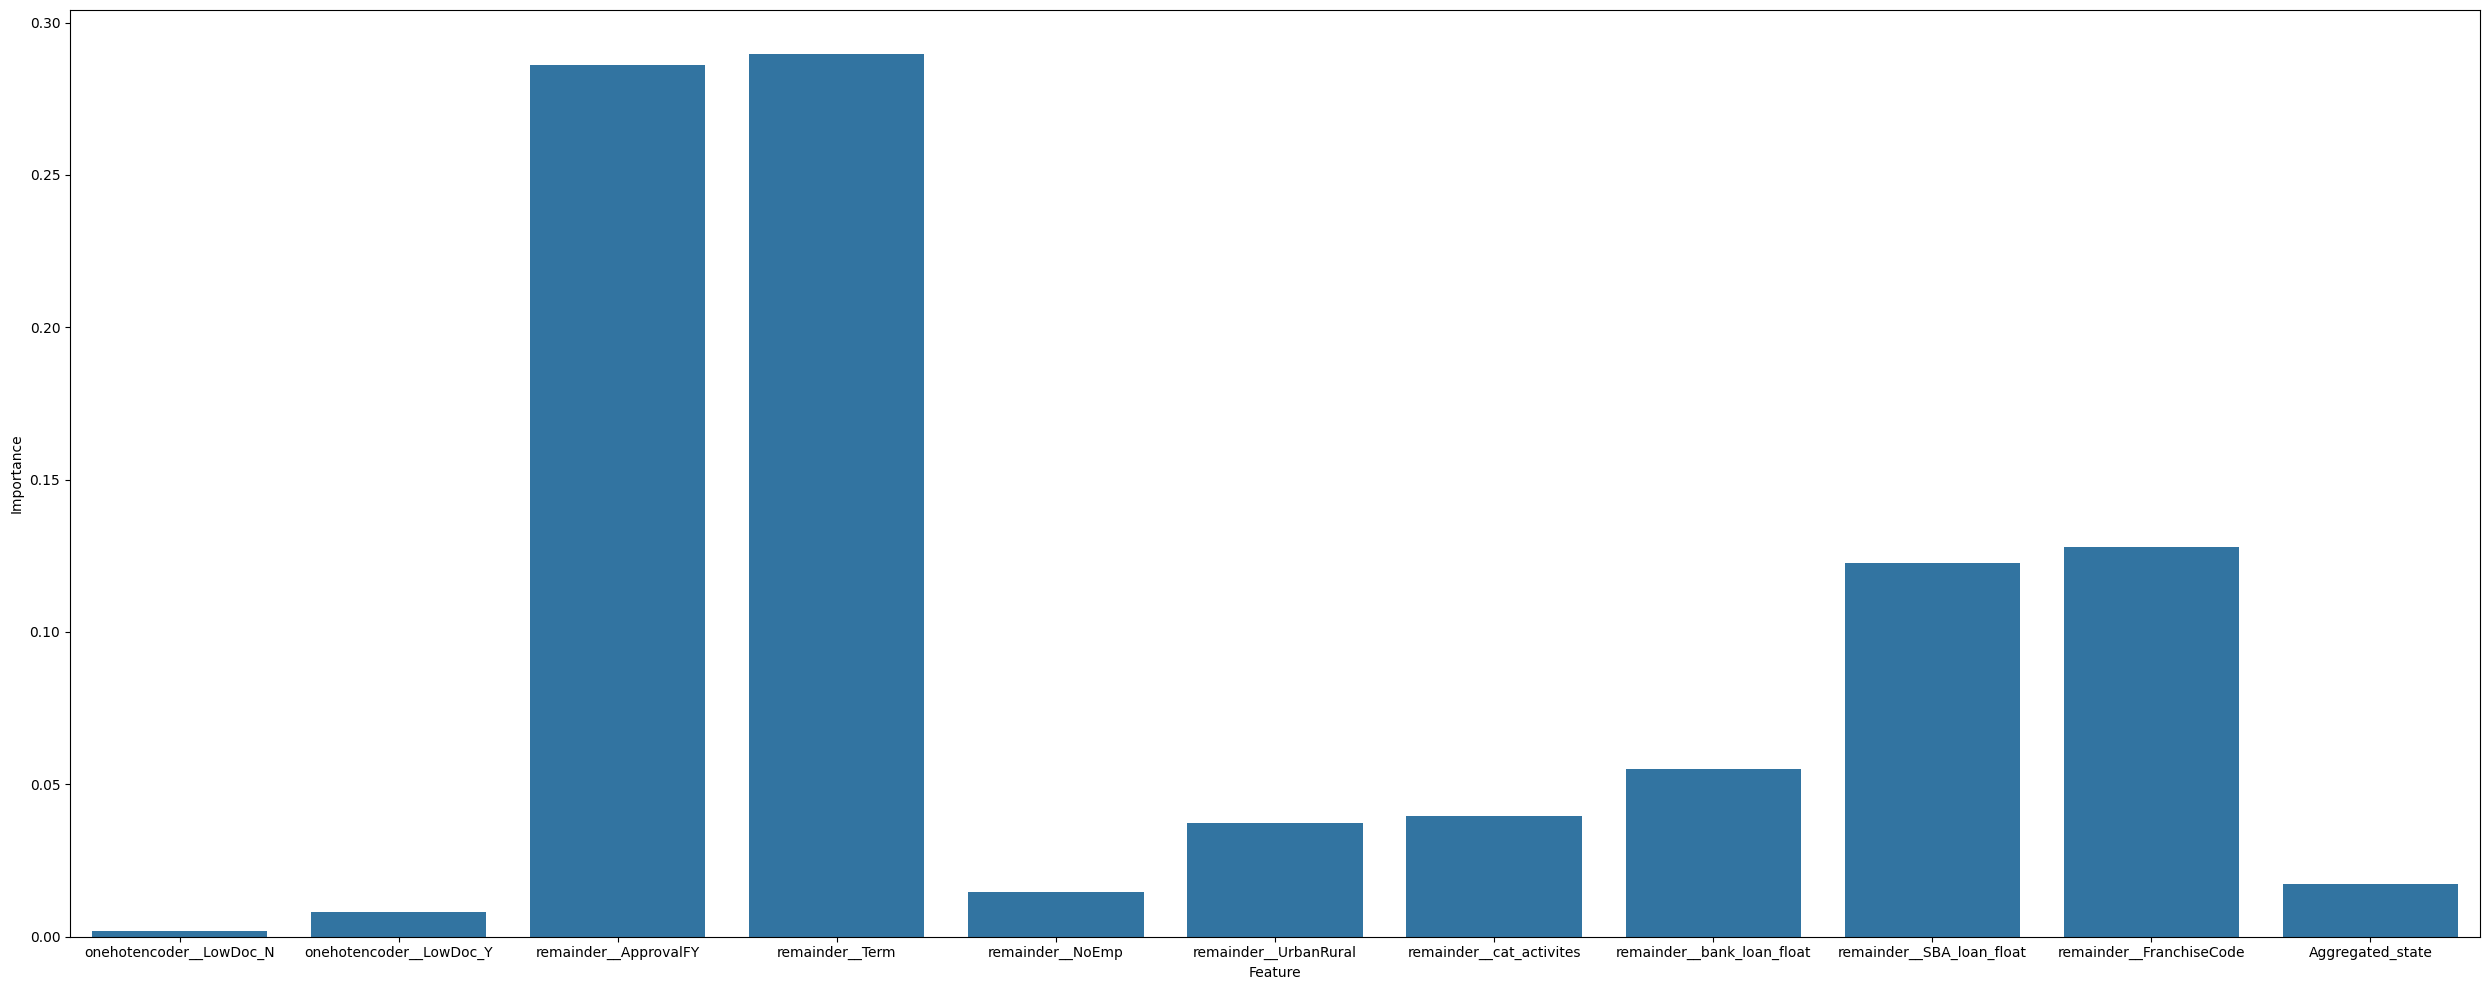

In [12]:
feature_names = model[0].get_feature_names_out()  # Extract feature names
importances = model[-1].feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance")
plt.tight_layout()
plt.show()

In [13]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

X_train_lgb[["State", "LowDoc"]] = X_train_lgb[["State", "LowDoc"]].astype("category")
X_test_lgb[["State", "LowDoc"]] = X_test_lgb[["State", "LowDoc"]].astype("category")



In [39]:
lgb = LGBMClassifier(learning_rate=0.5, n_estimators=100, max_depth=5)

lgb.fit(X_train_lgb, y_train)

[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1392
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(learning_rate=0.5, max_depth=5)

In [15]:
# cat_b = CatBoostClassifier()
# cat_b.fit(X_test_lgb, y_train)

In [18]:
print("Train score : ", lgb.score(X_train_lgb, y_train))
print("Test score : ", lgb.score(X_test_lgb, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.9461215179049165
Test score :  0.9441707352336043
ROC-AUC score : 0.5274265668546929
F1-Score :  0.9081198415521026


In [40]:
print("Train score : ", lgb.score(X_train_lgb, y_train))
print("Test score : ", lgb.score(X_test_lgb, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.9513683708435126
Test score :  0.9464839796701402
ROC-AUC score : 0.5274265668546929
F1-Score :  0.9081198415521026


In [35]:
lgb.get_params()



{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [36]:
param = {
    "learning_rate": np.linspace(0, 1, 11),
    "max_depth": [x for x in range(1, 6, 1)],
    "n_estimators": [x for x in range(10, 101, 10)]  
}

In [ ]:
search = RandomizedSearchCV(lgb, param, n_iter=100, scoring='f1_macro')

search_grid = search.fit(X_train_lgb, y_train)



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 340 .



[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 955, in fit

[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1392
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

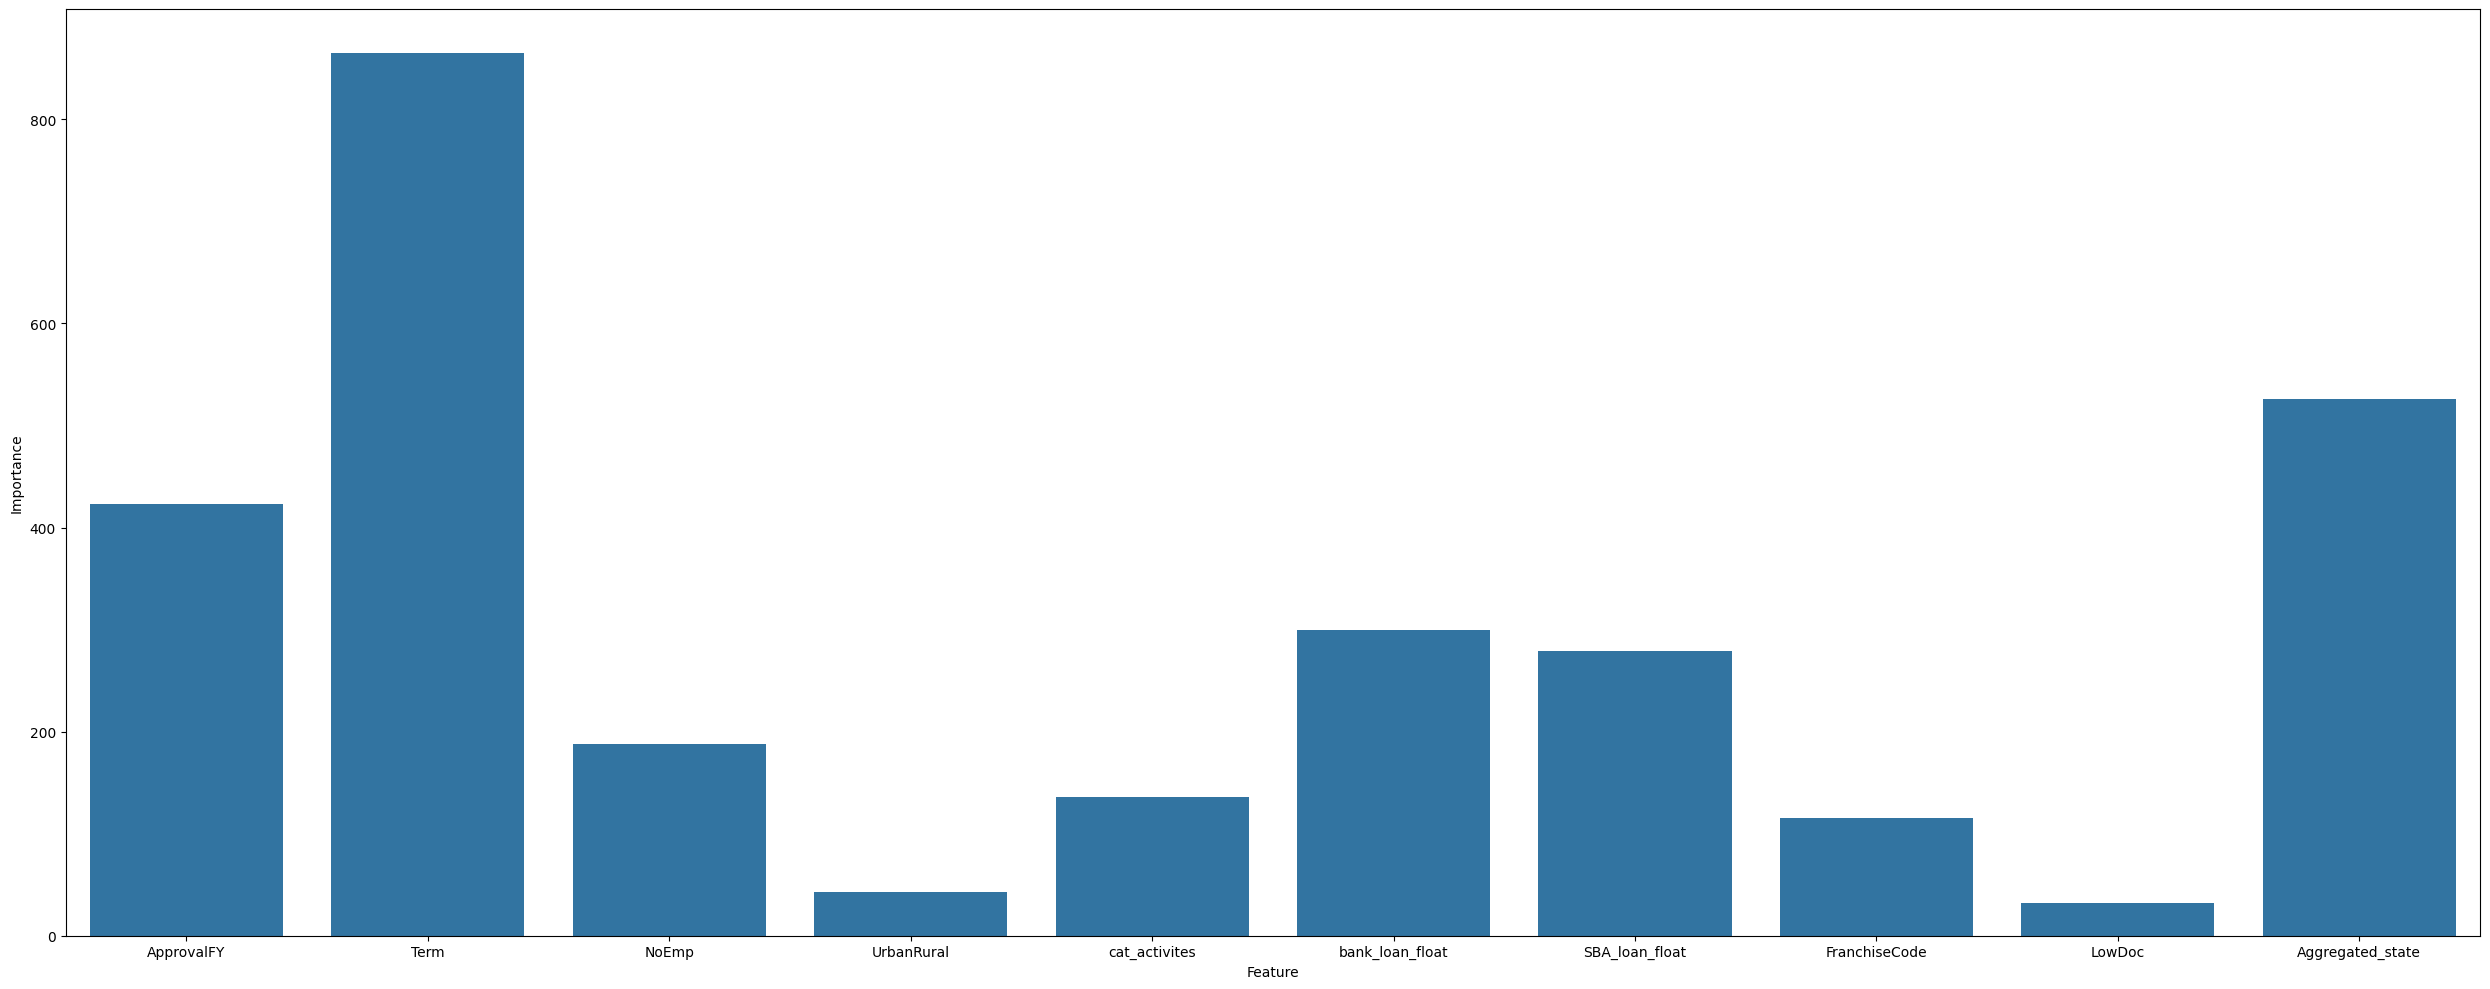

In [45]:

boost = lgb.booster_

feature_names = boost.feature_name()  # Extract feature names
importances = lgb.feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance")
plt.tight_layout()
plt.show()

In [ ]:
print(search_grid.best_params_)